In [ ]:
# trying plotting out

In [ ]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from botorch.models.transforms import Normalize, Standardize
from matplotlib import cm


In [ ]:
# Shubert - dim*3^dim global optima, many local optima, many smooth but localized optima (~760)
# x_i in [-10, 10]
def shubert_2d(x1, x2):
    x = [x1/ 20.0 + 0.5, x2/ 20.0 + 0.5]
    outer = torch.ones_like(x1)
    for i in range(2):
        inner = torch.zeros_like(x1)
        for j in range(5):
            inner += j*torch.cos( (j+1)*x[i] + j)
        outer = outer * inner
    return outer / 186.73

x1 = torch.arange(0., 1., 0.05)
x2 = torch.arange(0., 1., 0.05)
X1, X2 = torch.meshgrid([x1, x2])
Z = shubert_2d(X1, X2)
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'), figsize=(8,6))
surf = ax.plot_surface(X1, X2, Z, cmap=cm.inferno, shade=False)

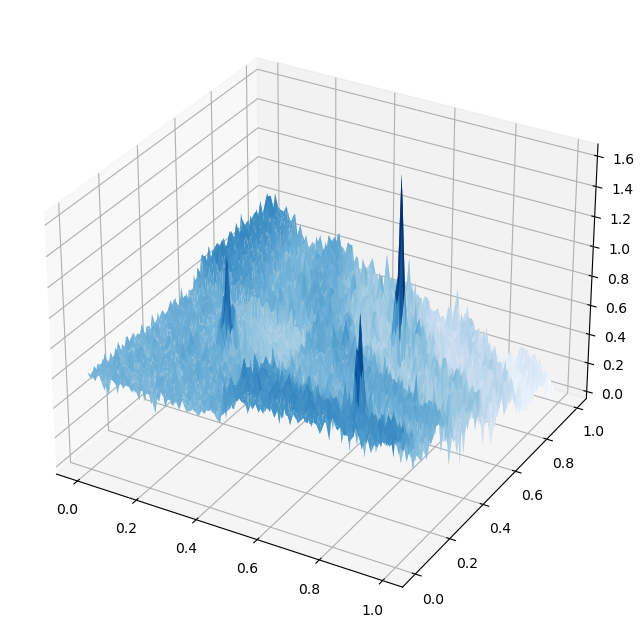

In [5]:
# visualizing with noise added
sigma_max = 0.12
sigma_min = 0.02
def noise_1_2d(x1, x2):
    # mean
    y = mme_add_2d_plot(x1, x2)
    # noise
    noise = torch.zeros(y.shape)
    noise += (torch.randn(y.shape) * sigma_max) * (x1 >= 0.61) * (x1 < 0.71) * (x2 >= 0.61) * (x2 < 0.71)  # peak 1
    noise += (torch.randn(y.shape) * sigma_max) * (x1 >= 0.21) * (x1 < 0.31) * (x2 >= 0.31) * (x2 < 0.41)  # peak 2
    noise += (torch.randn(y.shape) * sigma_max) * (x1 >= 0.76) * (x1 < 0.84) * (x2 >= 0.11) * (x2 < 0.21)  # peak 3
    # noise += (torch.randn(y.shape) * (sigma_max - sigma_min) / (1. + torch.exp(-10.*(x1-0.2))) + sigma_min) * (x1 < 0.5) * (x2 < 0.5)
    # noise += (torch.randn(y.shape) * (sigma_max - sigma_min) / (1. + torch.exp(10.*(x1-0.75))) + sigma_min) * (x1 >= 0.5) * (x2 >= 0.5)
    noise += torch.randn(y.shape) * (sigma_max - sigma_min) * (0.4 / (torch.abs(1.25*y - 0.5) + 0.4))
    # jump
    y1 = y + noise
    y_jump = 0.2 * y1 * (x1 <= 0.45) * (x2 <= 0.58)
    y2 = y1 - y_jump
    return y2

x1 = torch.arange(0.0, 1.0, 0.01)
x2 = torch.arange(0.0, 1.0, 0.01)
X1, X2 = torch.meshgrid([x1, x2])
Z = noise_1_2d(X1, X2)
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'), figsize=(10,8))
surf = ax.plot_surface(X1, X2, Z, cmap='Blues', shade=False, cstride=1, rstride=1, linewidth=0)
# plt.savefig(datasavedir + '/'+'2d_mme_noisyjump_surface'+'.png')

In [6]:
# formatting objective function to match the input format for botorch
sigma_max = 0.12
sigma_min = 0.02
def mme_add_2d(X):
    x1, x2 = X[..., 0], X[..., 1]
    y = (torch.exp(-(100.*(x1-0.65))**2.)) * (torch.exp(-(50.*(x2-0.65))**2.))
    y += 0.7*(torch.exp(-(100.*(x1-0.25))**2.)) * (torch.exp(-(50.*(x2-0.35))**2.))
    y += 0.8*(torch.exp(-(100.*(x1-0.8))**2.)) * (torch.exp(-(50.*(x2-0.15))**2.))
    y += 0.66*(-1.*x2*x1 + 0.1*torch.sin(30.*x1*x2)) + 0.73
    return y

def mme_2d(X):
    x1, x2 = X[..., 0], X[..., 1]
    # mean
    y = mme_add_2d(X)
    # noise
    noise = torch.zeros(y.shape)
    noise += (torch.randn(y.shape) * sigma_max) * (x1 >= 0.61) * (x1 < 0.71) * (x2 >= 0.61) * (x2 < 0.71)  # peak 1
    noise += (torch.randn(y.shape) * sigma_max) * (x1 >= 0.21) * (x1 < 0.31) * (x2 >= 0.31) * (x2 < 0.41)  # peak 2
    noise += (torch.randn(y.shape) * sigma_max) * (x1 >= 0.76) * (x1 < 0.84) * (x2 >= 0.11) * (x2 < 0.21)  # peak 3
    # noise += (torch.randn(y.shape) * (sigma_max - sigma_min) / (1. + torch.exp(-10.*(x1-0.2))) + sigma_min) * (x1 < 0.5) * (x2 < 0.5)
    # noise += (torch.randn(y.shape) * (sigma_max - sigma_min) / (1. + torch.exp(10.*(x1-0.75))) + sigma_min) * (x1 >= 0.5) * (x2 >= 0.5)
    noise += torch.randn(y.shape) * (sigma_max - sigma_min) * (0.4 / (torch.abs(1.25*y - 0.5) + 0.4))
    # jump
    y1 = y + noise
    y_jump = 0.2 * y1 * (x1 <= 0.45) * (x2 <= 0.58)
    y2 = y1 - y_jump
    return y2

def outcome_objective(x):
    """wrapper for the outcome objective function"""
    return mme_2d(x).type_as(x).unsqueeze(-1)